A Reconstruction of spontaneous ORN and PN activity proposed in [1] https://github.com/annkennedy/mushroomBody. Just the `getPNdynamics.m` script. Which models the ORNs PNs and LNs in the system.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

Getting Hallem and Carlson data

In [64]:
# Load in data
fp = "hc_data.csv"
df = pd.read_csv(fp)

# get ORN response of a specific odor
odor = 150
ORN_response = df.iloc[odor+1, 2:].astype(float)
ORN_spont = df.iloc[-1, 2:].astype(float)

# removing dm3 for some reason
ORN_response.pop("dm3")
ORN_spont.pop("dm3")

25.0

Initializing the model

In [65]:
# time
dt = 2e-3
time = np.arange(-1.5, 0.75, dt)

# odor stimulus
stim_on = 0.0
stim_off = 0.5
stim = np.where((time > stim_on) & (time < stim_off), 1, 0)

# Making ORN data into a time series (NOTE: Potentially unecessary to make a time varying model)
ORN_response = np.repeat(np.array(ORN_response)[:,None], len(time), axis=1)
ORN_spont = np.repeat(np.array(ORN_spont)[:,None], len(time), axis=1)

# Odor time series NOTE: odor is just ORN response, unsure if this is necessary
odor = stim * ORN_response + ORN_spont
ep = 0.0488 # taken from [1]
smooth_odor = np.copy(odor)
for i in range(1,odor.shape[1]):
    smooth_odor[:,i] = ep * odor[:,i] + (1 - ep) * smooth_odor[:,i-1] # exponential smoothing

In [59]:
# Constants
# Learned with least squares with Olsen model
k_1 = 368.6631
k_2 = 31.4088
c = 2.9410
g = 5.3395

# Set constants
LN_tau_gabaA = 0.1
LN_tau_gabaB = 0.4
ORN_tau = 0.01
PN_tau = 0.01
n = 3
LN_tau = 0.01
LN_thr = 1
LN_inhsc = 500 # parameters for "divisive inhibition"
LN_inhadd = 200

In [66]:
# time varying variable inititalizatoin
ORN = np.copy(ORN_spont)
PN_spont = ORN_spont * k_1 / (np.sum(ORN_spont[:,0]) + k_2)
PN = np.copy(PN_spont)
LN = np.ones_like(time) * 300
lnr = np.ones_like(time)
inhA = np.ones_like(time) * 50
inhB = np.ones_like(time) * 50
inh_PN = 0
inh_LN = 0

Running the model

In [67]:
for t, _ in enumerate(time):
    if i == 0:
        continue

    # Gaba A and Gaba B receptor dynamics
    inhA[t] = inhA[t-1] + (-inhA[t-1] + lnr[t-1]) * dt / LN_tau_gabaA
    inhB[t] = inhB[t-1] + (-inhB[t-1] + lnr[t-1]) * dt / LN_tau_gabaB

    # Neuron dynamics
    ORN[:,t] = ORN[:, t-1] + (-ORN[:,t-1] + smooth_odor[:,t]) * dt / ORN_tau
    PN[:,t] = PN[:,t-1] + (
        -PN[:,t-1] + PN_spont[:,t-1] + 200 * np.tanh((ORN[:,t-1] - ORN_spont[:,t-1] + c) * g/200 * inh_PN)
    ) * dt / PN_tau
    PN[:,t] = np.maximum(PN[:,t], 0)
    LN[t] = LN[t-1] + (-LN[t-1] + np.mean(ORN[:,t-1])**n * 51/23/2 * inh_LN) * dt / LN_tau # I don't really know why this is hardcoded
                                                                                             # after '**n'. in the text it's supposed to be k1' / (k2' + I_ln)
    lnr[t] = (LN[t] - LN_thr) * (LN[t] > LN_tau)

    # updating gaba inhibition for PNs and LNs
    inh_PN =  k_1 / (k_2 + 0.25 * inhA[t] + 0.75 * inhB[t])
    inh_LN = LN_inhsc / (LN_inhadd + inhA[t])

Plotting

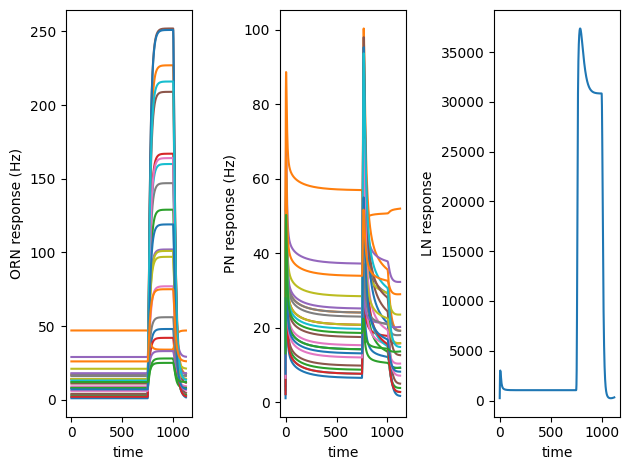

In [71]:
fig, axs = plt.subplots(1,3)
axs[0].plot(ORN.T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("ORN response (Hz)")
axs[1].plot(PN.T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("PN response (Hz)")
axs[2].plot(LN)
axs[2].set_xlabel("time")
axs[2].set_ylabel("LN response")
plt.tight_layout()
plt.show()

Saving PN time series to learn in another script

In [72]:
with open("sample_PN.pkl", "wb") as f:
    pkl.dump(PN, f)